<a href="https://colab.research.google.com/github/niwatoro/trader-company/blob/main/trader_company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from scipy.special import softmax

from dataclasses import dataclass
from numpy.typing import NDArray
from typing import Literal

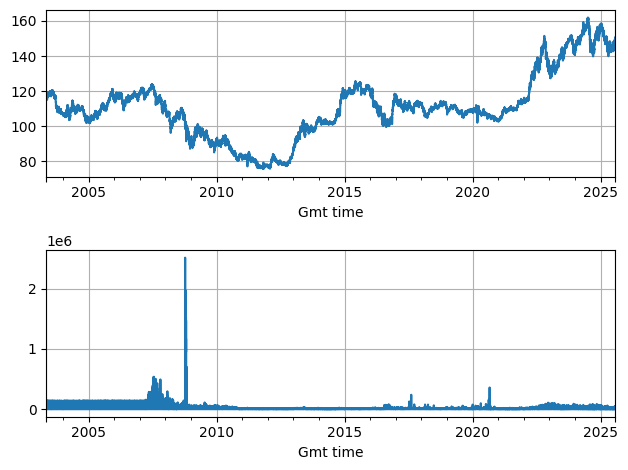

In [16]:
df_ninja = pd.read_csv("drive/MyDrive/USDJPY_Candlestick_1_Hour_BID_05.05.2003-02.08.2025.csv").iloc[:-30]
df_ninja["Gmt time"] = pd.to_datetime(df_ninja["Gmt time"], format="%d.%m.%Y %H:%M:%S.%f")
df_ninja["ma_20"] = df_ninja["Close"].rolling(20).mean()
df_ninja["ma_50"] = df_ninja["Close"].rolling(50).mean()
df_ninja["ret"] = np.log(df_ninja["Close"] / df_ninja["Close"].shift(1))
df_ninja.dropna(inplace=True)

fig, axes = plt.subplots(2, 1)
df_ninja.set_index("Gmt time", inplace=True)
df_ninja["Close"].plot(ax=axes[0], grid=True)
df_ninja["Volume"].plot(ax=axes[1], grid=True)
plt.tight_layout()
plt.show()

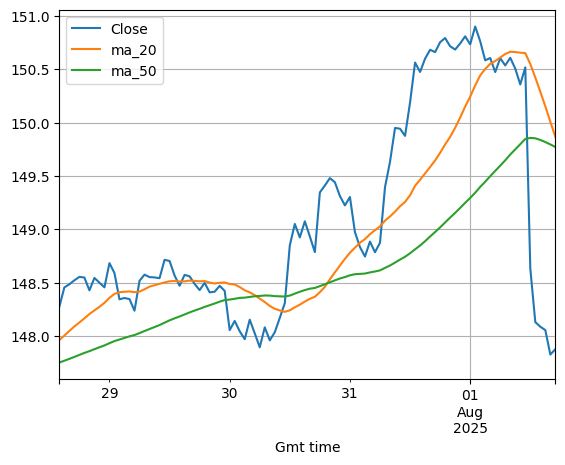

In [17]:
df_ninja.loc[df_ninja.index[-100:], ["Close", "ma_20", "ma_50"]].plot(grid=True)
plt.show()

In [18]:
df_ninja

,Open,High,Low,Close,Volume,ma_20,ma_50,ret
Gmt time,,,,,,,,
2003-05-07 01:00:00,117.601,117.757,117.565,117.597,13065.80,117.97435,118.43630,-0.000459
2003-05-07 02:00:00,117.620,117.748,117.587,117.669,11511.40,117.92980,118.41028,0.000612
2003-05-07 03:00:00,117.661,117.830,117.648,117.743,12961.70,117.89085,118.38660,0.000629
2003-05-07 04:00:00,117.676,117.791,117.664,117.700,11726.70,117.85610,118.36214,-0.000365
2003-05-07 05:00:00,117.676,117.723,117.543,117.621,11312.80,117.82400,118.33536,-0.000671
...,...,...,...,...,...,...,...,...
2025-08-01 13:00:00,148.631,148.660,147.983,148.131,56407.17,150.42370,149.85406,-0.003390
2025-08-01 14:00:00,148.116,148.223,147.482,148.088,30600.72,150.29035,149.83880,-0.000290
2025-08-01 15:00:00,148.091,148.184,147.929,148.056,15745.37,150.15345,149.81890,-0.000216


In [19]:
OPERATIONS = {
    "add": lambda x, y: x + y,
    "sub": lambda x, y: x - y,
    "mul": lambda x, y: x * y,
    "x": lambda x, y: x,
    "y": lambda x, y: y,
    "max": lambda x, y: np.maximum(x, y),
    "min": lambda x, y: np.minimum(x, y),
    "gt": lambda x, y: np.sign(x - y),
    "lt": lambda x, y: np.sign(y - x),
}

In [20]:
ACTIVATIONS = {
    "id": lambda x: x,
    "relu": lambda x: np.maximum(0, x),
    "tanh": lambda x: np.tanh(x),
    "exp": lambda x: np.exp(np.clip(x, -20, 20)),
    "sign": lambda x: np.sign(x),
}

トレーダーは以下の式に基づいて、1期間後のリターンを予測する。$r_{1:S}[0:t]$は金融商品$1$から$S$の期間$0$から$t$までのリターンである。また$M$は予測式の項数、$w_j$は重み、$A_j$は活性化間数、$O_j$は二項演算、$P_j,Q_j$は予測に使う金融商品のインデックスである。

$$f_\Theta(r_{1:S}[0:t])=\sum_{j=1}^Mw_jA_j(O_j(r_{P_j}[t-D_j],r_{Q_j}[t-F_j]))$$

ここで$\Theta$はトレーダーのパラメーターである。

$$\Theta:=\{M,\{P_j,Q_j,D_j,F_j,O_j,A_j,w_j\}_{j=1}^{M}\}$$

In [21]:
@dataclass
class Term:
  P: int
  Q: int
  D: int
  F: int
  O: str
  A: str

In [22]:
class Trader:
  M: int
  terms: list[Term]
  w: NDArray[np.float64]

  def __init__(
      self,
      rng: random.Random,
      S: int,
      M_range: tuple[int, int]=(1, 10),
      delay_range: tuple[int, int]=(0, 10)
  ) -> None:
    self.M = rng.randint(M_range[0], M_range[1])
    self.terms = [
        Term(
            P=rng.randint(0, S - 1),
            Q=rng.randint(0, S - 1),
            D=rng.randint(delay_range[0], delay_range[1]),
            F=rng.randint(delay_range[0], delay_range[1]),
            O=rng.choice(list(OPERATIONS.keys())),
            A=rng.choice(list(ACTIVATIONS.keys())),
        )
        for _ in range(self.M)
    ]
    self.w = np.array([rng.uniform(-1., 1.) for j in range(self.M)])

  def _calculate_X(self, r: NDArray[np.float64]) -> NDArray[np.float64]:
    T = r.shape[0]
    X = np.zeros((self.M, T), dtype=np.float64)
    t = np.arange(T)
    for j, term in enumerate(self.terms):
      mask = (t - term.D >= 0) & (t - term.F >= 0)
      column = np.zeros(T, dtype=np.float64)
      column[mask] = ACTIVATIONS[term.A](OPERATIONS[term.O](
          r[t[mask] - term.D, term.P],
          r[t[mask] - term.F, term.Q]
      ))
      X[j] = column
    return X

  def predict(self, r: NDArray[np.float64]) -> NDArray[np.float64]:
    return self.w@self._calculate_X(r)

  def learn(self, r: NDArray[np.float64], r_target: NDArray[np.float64], alpha: float=1e-6) -> None:
    X = self._calculate_X(r)
    T = r.shape[0]
    t = np.arange(T - 1)

    mask = t >= 0
    for term in self.terms:
      mask &= (t - term.D >= 0) & (t - term.F >= 0)

    F = X[:, :-1].T[mask]
    y = r_target[1:][mask]
    A = F.T@F + alpha * np.eye(self.M)
    b = F.T@y

    self.w = np.linalg.pinv(A)@b

  def calculate_cumulative_returns(
      self,
      r: NDArray[np.float64],
      r_target: NDArray[np.float64]
  ) -> NDArray[np.float64]:
    preds = self.predict(r)
    return np.cumsum(np.sign(preds[:-1]) * r_target[1:])

カンパニーはトレーダーの意見を集約する。ここで$N$をトレーダーの数とすると、最終的な予測値$\widehat r[0:t]$は以下の式で与えられる。

$$\widehat r[0:t]=\text{Aggregate}(f_{\Theta_1},\dots,f_{\Theta_N})$$

なお、Aggregate関数には様々な定義がありうる。
- ${1\over N}\sum_{n=1}^Nf_{\Theta_n}(r_{1:S}[0:t])$
- $\sum_{n=1}^Nw_nf_{\Theta_n}(r_{1:S}[0:t])$
  - $X_{nt}:=(f_{\Theta_n}(r_{1:S}[0:t]))$
  - $(w_1,\dots,w_N):=r[0:t]^TX$

また、カンパニーは成績が悪いトレーダーに対して教育を行う。リターンが下位$Q$パーセンタイル以下のトレーダーの$w$を、以下の式を満たす$w$で更新する。

$$r[0:t]=wX$$

教育後、リターンが下位$Q$パーセンタイル以下のトレーダーのパラメーター$\Theta$をサンプリングする。元論文ではガウス混合分布からサンプリングしていたが、ここでは簡便のため一様分布からサンプリングする。

なお、時刻$t$の累積リターン$C[t]$は以下の式で計算される。

$$C[t]=\sum_{u=0}^t\text{sign}(\widehat r[u+1])r[u+1]$$

In [26]:
class Company:
  rng: random.Random
  S: int
  N: int
  Q: float
  aggregator: Literal["average", "linear", "linear_prior"]
  traders: list[Trader]
  agg_coefs: NDArray[np.float64]
  scoring: list[Literal["cumlative_returns", "sharpe_ratio", "correlatioon"]]

  def __init__(
      self,
      rng: random.Random,
      S: int,
      N: int=100,
      Q: float=.25,
      aggregator: Literal["average", "linear", "linear_prior"]="linear_prior",
      scoring: list[
          Literal["cumlative_returns", "sharpe_ratio", "correlatioon"]
      ]=["sharpe_ratio", "correlation"]
  ) -> None:
    self.rng = rng
    self.S = S
    self.N = N
    self.Q = Q
    self.aggregator = aggregator
    self.traders = [Trader(rng=self.rng, S=S) for n in range(N)]
    self.scoring = scoring

    self.agg_coefs = np.ones(self.N, dtype=np.float64) / self.N

  def aggregate(self, r: NDArray[np.float64]) -> NDArray[np.float64]:
    preds = np.vstack([trader.predict(r) for trader in self.traders])
    return self.agg_coefs@preds

  def fit_aggregator(
      self,
      r: NDArray[np.float64],
      r_target: NDArray[np.float64],
      alpha: float=1e-6,
      prior_strength: float=2.
  ) -> None:
    if self.aggregator == "average":
      self.agg_coefs = np.ones(self.N, dtype=np.float64) / self.N
    else:
      preds = np.vstack([tr.predict(r) for tr in self.traders])
      Z = preds[:, :-1].T
      y = r_target[1:]

      if self.aggregator == "linear":
        A = Z.T@Z + alpha * np.eye(self.N)
        b = Z.T@y

        self.agg_coefs = np.linalg.pinv(A)@b
      elif self.aggregator == "linear_prior":
        scores = self.calculate_scores(r, r_target)
        zs = self._z(scores)
        g = np.exp(-prior_strength * zs)
        Gamma = np.diag(g.astype(np.float64))

        A = Z.T@Z + alpha * Gamma
        b = Z.T@y

        self.agg_coefs = np.linalg.pinv(A)@b
      else:
        raise ValueError(f"Unknown aggregator: {self.aggregator}")

  def calculate_cumulative_returns(self, r: NDArray, r_target: NDArray):
    preds = self.aggregate(r)
    cum_rets = np.cumsum(np.sign(preds[:-1]) * r_target[1:])
    return cum_rets

  def calculate_returns_traders(self, r: NDArray, r_target: NDArray) -> NDArray:
    preds = np.vstack([tr.predict(r) for tr in self.traders]).T
    rets = np.sign(preds[:-1]) * r_target[1:].reshape(-1, 1)
    return rets

  def calculate_sharpe_ratio_traders(self, r: NDArray, r_target: NDArray) -> NDArray:
    rets = self.calculate_returns_traders(r, r_target)
    std = np.nanstd(rets, axis=0)
    sharpe_ratios = np.nanmean(rets, axis=0) / np.where((std == 0) | ~np.isfinite(std), np.nan, std)
    return np.nan_to_num(sharpe_ratios)

  def calculate_correlation_traders(self, r: NDArray, r_target: NDArray) -> NDArray:
    rets_traders = self.calculate_returns_traders(r, r_target)
    rets_aggregated = rets_traders@self.agg_coefs

    std_traders = np.nanstd(rets_traders, axis=0)
    std_agg = np.nanstd(rets_aggregated)

    bad = (std_traders == 0) | (std_agg == 0)

    correlations = np.array([
        np.corrcoef(rets_traders[:, n], rets_aggregated)[0, 1]
        if not bad[n] else .0
        for n in range(self.N)
    ])
    return np.nan_to_num(correlations)

  @staticmethod
  def _z(x: NDArray, epsilon: float=1e-12) -> NDArray:
    return (x - np.mean(x)) / (np.std(x) + epsilon)

  def calculate_scores(self, r: NDArray[np.float64], r_target: NDArray[np.float64]) -> NDArray:
    scores = np.zeros(self.N, dtype=np.float64)
    for scr in self.scoring:
      if scr == "cumlative_returns":
        scores += self._z(self.calculate_cumulative_returns_traders(r, r_target))
      elif scr == "sharpe_ratio":
        scores += self._z(self.calculate_sharpe_ratio_traders(r, r_target))
      elif scr == "correlation":
        scores += self._z(1. - np.abs(self.calculate_correlation_traders(r, r_target)))
      else:
        raise ValueError(f"Unknown scoring function: {scr}")
    return scores

  def _find_bad_traders(self, r: NDArray[np.float64], r_target: NDArray[np.float64]) -> list[int]:
    scores = self.calculate_scores(r, r_target)
    threshold = np.percentile(scores, self.Q * 100.)
    bad_idx = np.where(scores < threshold)[0].tolist()
    return bad_idx

  def educate(self, r: NDArray[np.float64], r_target: NDArray[np.float64]) -> None:
    bad_idx = self._find_bad_traders(r, r_target)
    for id in bad_idx:
      self.traders[id].learn(r, r_target)

  def dismiss_bad_traders_and_recruit_new(self, r: NDArray[np.float64], r_target: NDArray[np.float64]) -> None:
    bad_idx = self._find_bad_traders(r, r_target)
    for id in bad_idx:
      self.traders[id] = Trader(rng=self.rng, S=self.S)

  def fit(self, r: NDArray, r_target: NDArray):
    self.educate(r, r_target)
    self.dismiss_bad_traders_and_recruit_new(r, r_target)
    self.fit_aggregator(r, r_target)

In [27]:
def train_and_evaluate(X: pd.DataFrame, y: pd.Series, test_size: float=.2, epochs: int=1):
  r = X.values
  r_target = y.values

  T, S = r.shape
  t_split = int(T * (1 - test_size))

  r_target_train = r_target[:t_split]
  r_target_test = r_target[t_split:]
  r_train = r[:t_split]
  r_test = r[t_split:]

  rng = random.Random(123)
  company = Company(rng=rng, S=S)

  for epoch in tqdm(range(epochs)):
    company.fit(r_train, r_target_train)

  cumlative_returns = company.calculate_cumulative_returns(r, r_target)

  plt.plot(X.index[1:], cumlative_returns)
  plt.axvline(X.index[t_split], color="C3")
  plt.grid()
  plt.show()

  scores = company.calculate_scores(r, r_target)
  plt.hist(scores, bins=20)
  plt.grid()
  plt.show()

100%|██████████| 2/2 [00:18<00:00,  9.36s/it]


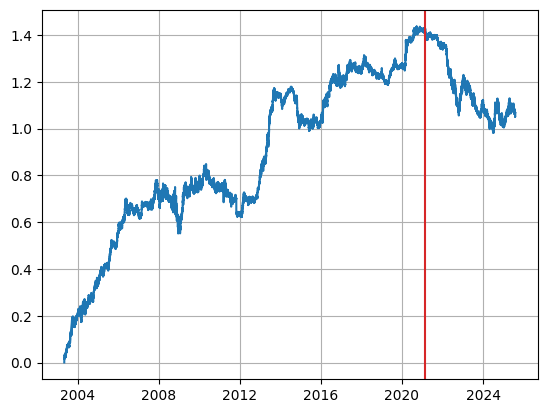

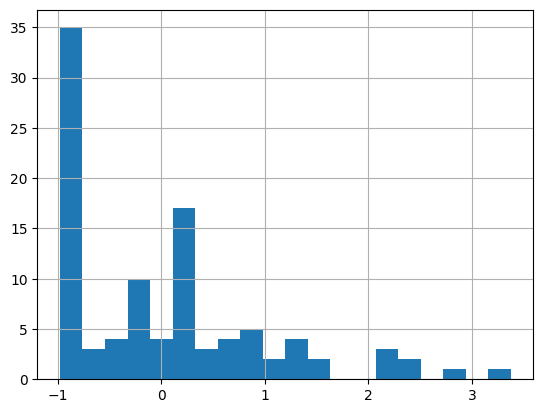

In [29]:
train_and_evaluate(df_ninja[["ret", "Close", "ma_20", "ma_50", "Volume"]], df_ninja["ret"], epochs=2)